<a href="https://colab.research.google.com/github/nasarar/Post_Covid19_Vacation_Projection/blob/main/pcvplanner_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post Covid_19 Vacation Planner 

## Your gateway to safe travel 

In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

In [2]:
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import pandas as pd

# Data Collection : Source - https://covid.ourworldindata.org/

In [3]:
import pandas as pd

#load dataset
pcv= pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
print('Shape of data',pcv.shape)
pcv.head()
pcv

Shape of data (92885, 59)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92880,ZWE,Africa,Zimbabwe,2021-05-28,38918.0,64.0,36.286,1592.0,0.0,0.857,2618.461,4.306,2.441,107.112,0.000,0.058,1.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1833.0,546389.0,36.762,0.123,1727.0,0.116,0.021,47.6,tests performed,976796.0,656630.0,320166.0,23407.0,12695.0,6.57,4.42,2.15,854.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
92881,ZWE,Africa,Zimbabwe,2021-05-29,38933.0,15.0,36.286,1594.0,2.0,1.143,2619.471,1.009,2.441,107.247,0.135,0.077,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2032.0,548421.0,36.899,0.137,1790.0,0.120,0.020,49.3,tests performed,1002465.0,666786.0,335679.0,25669.0,14056.0,6.74,4.49,2.26,946.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
92882,ZWE,Africa,Zimbabwe,2021-05-30,38944.0,11.0,37.429,1594.0,0.0,1.143,2620.211,0.740,2.518,107.247,0.000,0.077,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1011973.0,670755.0,341218.0,9508.0,14420.0,6.81,4.51,2.30,970.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
92883,ZWE,Africa,Zimbabw

# ARIMA Model process & Dependencies 

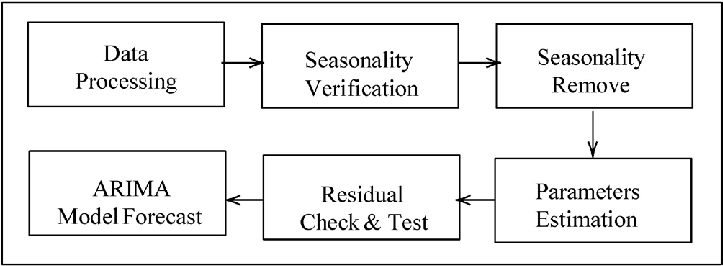

In [4]:
!pip install pmdarima 

     |████████████████████████████████| 1.5MB 4.0MB/s 
     |████████████████████████████████| 9.5MB 37.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Import Dependencies 

In [5]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

## Adding ID to data set 

In [6]:
country = "CAN"
pcv = pcv.sort_values('location')
pcv['eid'] = (pcv.groupby(['location']).cumcount()==0).astype(int)
pcv['eid'] = pcv['eid'].cumsum()
pcvdf=pcv[pcv.iso_code==country]
#check dataframe of GBR
fpcvdf = pcvdf.sort_values('people_fully_vaccinated')
fpcvdf

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,eid
15367,CAN,North America,Canada,2021-01-06,631466.0,8082.0,7742.857,16539.0,150.0,127.000,16731.052,214.137,205.151,438.210,3.974,3.365,1.11,850.0,22.521,4651.0,123.231,NaN,NaN,NaN,NaN,83472.0,18597612.0,492.754,2.212,104774.0,2.776,0.074,13.5,tests performed,183360.0,182930.0,430.0,28163.0,14174.0,0.49,0.48,0.00,376.0,73.61,37742157.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,38
15368,CAN,North America,Canada,2021-01-07,639693.0,8227.0,7897.714,16704.0,165.0,134.571,16949.031,217.979,209.254,442.582,4.372,3.566,1.09,844.0,22.362,4592.0,121.668,NaN,NaN,NaN,NaN,118708.0,18716320.0,495.900,3.145,107318.0,2.843,0.074,13.6,tests performed,219446.0,218359.0,1087.0,36086.0,17409.0,0.58,0.58,0.00,461.0,73.61,37742157.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,38
15369,CAN,North America,Canada,2021-01-08,648930.0,9237.0,9075.714,16846.0,142.0,148.571,17193.771,244.740,240.466,446.344,3.762,3.936,1.07,848.0,22.468,4554.0,120.661,NaN,NaN,NaN,NaN,135490.0,18851810.0,499.489,3.590,107741.0,2.855,0.084,11.9,tests performed,260654.0,258627.0,2027.0,41208.0,22409.0,0.69,0.69,0.01,594.0,73.61,37742157.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,38
15370,CAN,North America,Canada,2021-01-09,657323.0,8393.0,9626.857,16984.0,138.0,152.857,17416.148,222.377,255.069,450.001,3.656,4.050,1.04,863.0,22.866,4527.0,119.945,NaN,NaN,NaN,NaN,146263.0,18998073.0,503.365,3.875,109729.0,2.907,0.088,11.4,tests performed,296241.0,293301.0,2940.0,35587.0,26787.0,0.78,0.78,0.01,710.0,75.46,37742157.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,38
15371,CAN,North America,Canada,2021-01-10,664606.0,7283.0,8361.429,17074.0,90.0,152.571,17609.115,192.967,221.541,452.385,2.385,4.042,1.00,862.0,22.839,4525.0,119.892,NaN,NaN,NaN,NaN,141597.0,19139670.0,507.116,3.752,113871.0,3.017,0.073,13.6,tests performed,319603.0,316661.0,2942.0,23362.0,29367.0,0.85,0.84,0.01,778.0,75.46,37742157.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15184,CAN,North America,Canada,2020-07-07,108023.0,208.0,275.143,8843.0,7.0,9.000,2862.131,5.511,7.290,234.300,0.185,0.238,0.95,70.0,1.855,582.0,15.420,NaN,NaN,NaN,NaN,32124.0,3177228.0,84.182,0.851,40380.0,1.070,0.007,146.8,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.98,37742157.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,38
15185,CAN,North America,Canada,2020-07-08,108334.0,311.0,292.286,8855.0,12.0,9.286,2870.371,

In [7]:
pcvval = fpcvdf['people_fully_vaccinated'].values * 100 /list(pcvdf.population)[0]


# Stationary Verification 

### Adding two order differencing to make Time series stationary to avoid trend and seasonability 

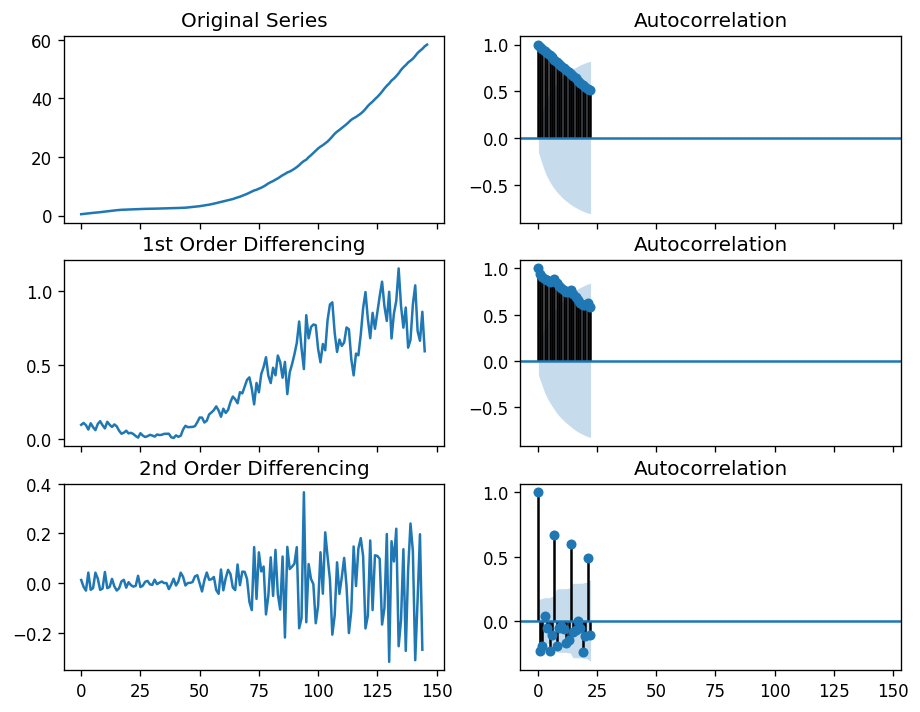

In [8]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
country_list = ['CAN']
for country in country_list:
  pcv = pcv.sort_values('location')
  pcv['eid'] = (pcv.groupby(['location']).cumcount()==0).astype(int)
  pcv['eid'] = pcv['eid'].cumsum()
  pcvdf=pcv[pcv.iso_code==country]
  #check dataframe of GBR
  fpcvdf = pcvdf.sort_values('people_vaccinated')
  pcvval = fpcvdf['people_vaccinated'].values * 100 /list(pcvdf.population)[0]

  for i in range(len(pcvval)):
    if pcvval[i]>=0:
      pass
    else :
      end = i
      break
  pcvval = pcvval[:end]
  d = list(fpcvdf.date)[:end]
  fig, axes = plt.subplots(3, 2, sharex=True)
  axes[0, 0].plot(pcvval); axes[0, 0].set_title('Original Series')
  plot_acf(pcvval, ax=axes[0, 1])
   # 1st Differencing
  axes[1, 0].plot(np.diff(pcvval)); axes[1, 0].set_title('1st Order Differencing')
  plot_acf(np.diff(pcvval), ax=axes[1, 1])
  dpcvval = np.diff(pcvval)

  # 2nd Differencing
  axes[2, 0].plot(np.diff(dpcvval)); axes[2, 0].set_title('2nd Order Differencing')
  plot_acf(np.diff(dpcvval), ax=axes[2, 1])
  plt.show()


## Best Model chosen is : ARIMA (p,d,q) = ARIMA(4,4,2)



In [9]:
model = pm.auto_arima(pcvval, start_p=1, start_q=1,
  test='adf', # use adftest to find optimal 'd'
  max_p=4, max_q=4, # maximum p and q
  m=1, # frequency of series
  d=None, # let model determine 'd'
  seasonal=False, # No Seasonality
  start_P=0,
  D=0,
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True)
print(model.summary())
  # model.plot_diagnostics(figsize=(7,5))
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-257.075, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-230.521, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-236.723, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-248.131, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-232.373, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-256.522, Time=0.34 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-256.629, Time=0.33 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-258.629, Time=0.19 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-256.629, Time=0.31 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-260.540, Time=0.54 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-268.536, Time=0.73 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-270.552, Time=0.43 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=-267.626, Time=0.19 sec

Best model:  ARIMA(0,2,4)(0,0,0)[0] i

# Arima Model  Forecast :12*30 - 360 days 

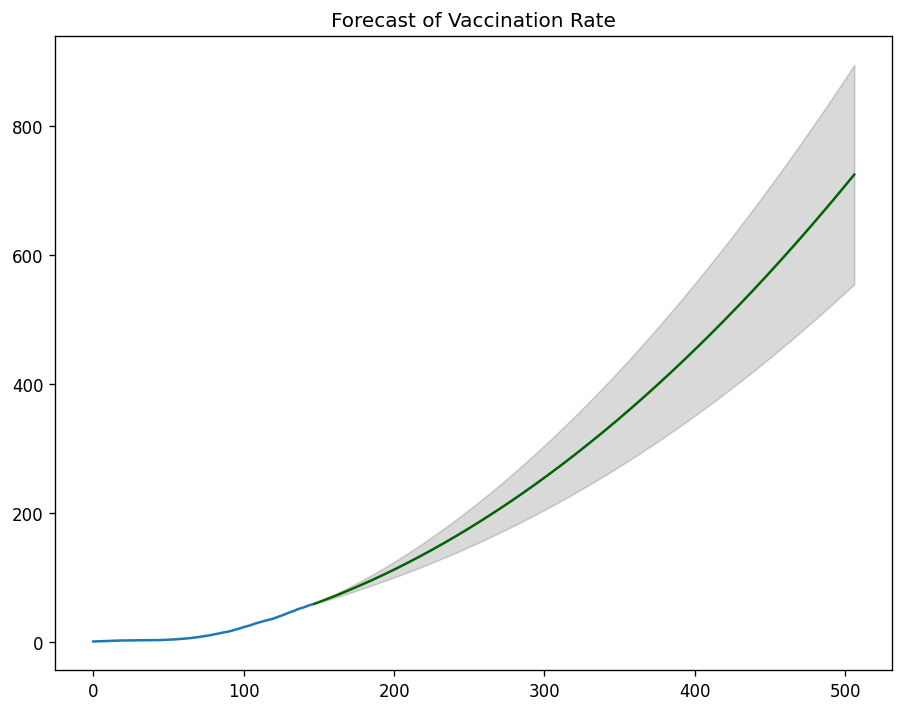

In [12]:
 # Forecasting 
n_periods = 12*30
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(pcvval), len(pcvval)+n_periods)
 # make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
 # Plot
plt.plot(pcvval)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='k', alpha=.15)
plt.title("Forecast of Vaccination Rate")
plt.show()
for i in range(n_periods):
  date = parse(d[-1]) + datetime.timedelta(days=1)
  d.append(str(date).split()[0])
y = list(pcvval) + list(fc)
dfp = pd.DataFrame()
dfp['date'] = d
dfp['people_fully_vaccinated'] = y
dfp.to_csv(f'{country}_predictions.csv')


## Adding Lag to stabilize different gaps between two doses 

In [13]:
# Herd immunity of 70% will reach in # of days 
for i,x in enumerate(fc):
  if x > 70:
    print(i+1)
    break

14


In [14]:
vaccinated = (fpcvdf.dropna(subset=["people_vaccinated"])["people_vaccinated"]*100/list(pcvdf.population)[0]).tolist()
fully_vaccinated = (fpcvdf.dropna(subset=["people_vaccinated"])["people_fully_vaccinated"]*100/list(pcvdf.population)[0]).tolist()

In [16]:
# Lag between two doses 
import math

lagMin = 0
mseMin = math.inf
for lag in range(0,139):
  vacNew = vaccinated[:len(vaccinated)-lag]
  fullVacNew = fully_vaccinated[lag:]
  mse = 0
  for i in range(len(vacNew)):
    mse += (vacNew[i] - fullVacNew[i])**2
  mse = mse/len(vacNew)
  if mse < mseMin:
    lagMin = lag
    mseMin = mse
lagMin

79

In [17]:
lag = lagMin
vacNew = vaccinated[:len(vaccinated)-lag]
fullVacNew = fully_vaccinated[lag:]

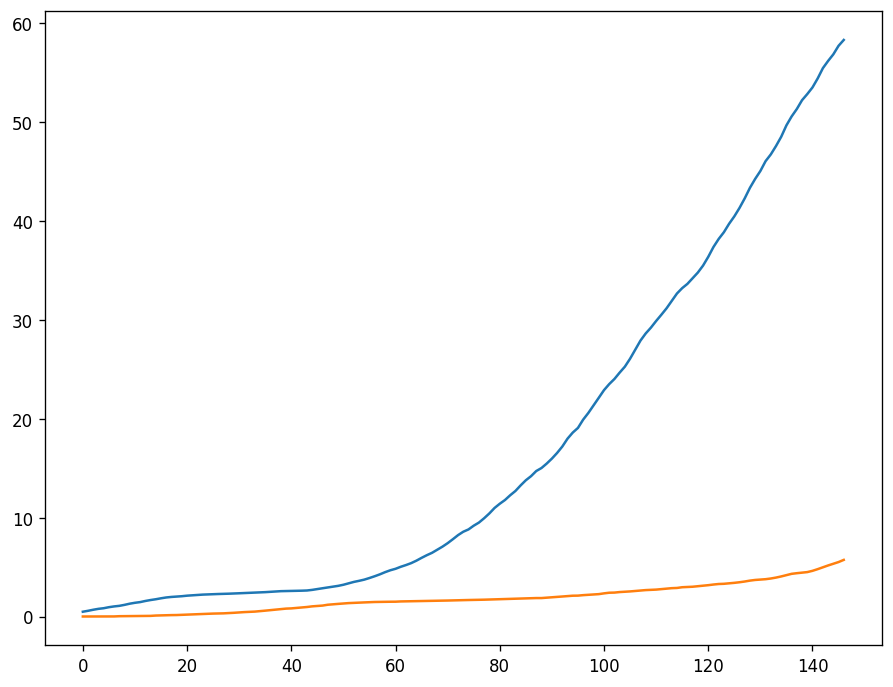

In [18]:
plt.plot(range(len(vaccinated)),vaccinated)
plt.plot(range(len(vaccinated)),fully_vaccinated)

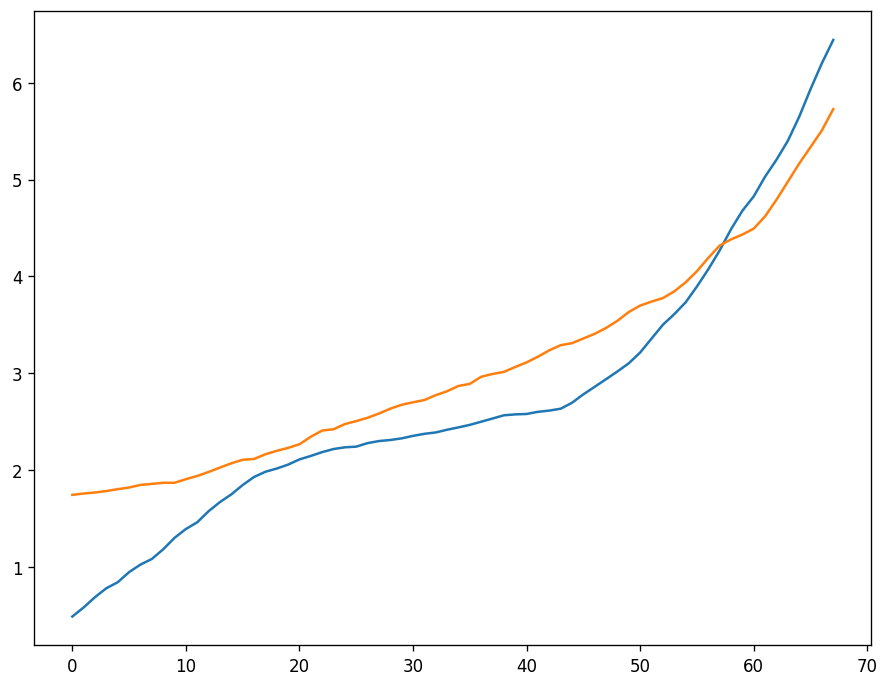

In [19]:
plt.plot(range(len(vacNew)),vacNew)
plt.plot(range(len(fullVacNew)),fullVacNew)